In [1]:
import copy
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt

from causal_convolution import DCConvStack
from sktime.utils.load_data import load_from_arff_to_dataframe

# Augmentation in Time Series

## Data Loading

In [5]:
# Install and import of https://pypi.org/project/uea-ucr-datasets/
![ -z "$(pip list | grep 'Cython')" ] && pip install Cython
![ -z "$(pip list | grep 'uea-ucr-datasets')" ] && pip install uea-ucr-datasets

Path('./data').mkdir(exist_ok=True)
%env UEA_UCR_DATA_DIR={Path.cwd()}/data
import uea_ucr_datasets as ucr_ds

env: UEA_UCR_DATA_DIR=/home/lukoshkin/Dropbox/iprog/Skoltech/ml_2020/project/data


In [6]:
# Download univariate dataset (preprocessed by sktime)
url = ('http://www.timeseriesclassification.com/'
       'Downloads/Archives/Univariate2018_ts.zip')
try:
    is_empty = not any(Path('./data').iterdir())
except FileNotFoundError:
    is_empty = True
if is_empty:
    !wget -O data/archive.zip {url}

In [7]:
# Extract files from the archive
!unzip -qn ./data/archive.zip -d data
!mv -n data/Univariate_ts/* data
!rmdir data/Univariate_ts 2> /dev/null
# Output some folder names below
!ls ./data | head -10

ACSF1
Adiac
AllGestureWiimoteX
AllGestureWiimoteY
AllGestureWiimoteZ
archive.zip
ArrowHead
Beef
BeetleFly
BirdChicken


In [8]:
# Data Description
!head -8 data/Coffee/Coffee_TRAIN.ts

#"FoodFood spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012.
@problemName Coffee
@timeStamps false
@missing false
@univariate true
@equalLength true
@seriesLength 286
@classLabel true 0 1


In [9]:
train_ds = ucr_ds.Dataset('Coffee', train=True)
test_ds = ucr_ds.Dataset('Coffee', train=False)

In [10]:
train_ds.data_x.head()

,dim_0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...


In [11]:
train_ds.data_y

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1'], dtype='<U1')

## Writing a DataLoader

In [11]:
class SimpleTSDataset(Dataset):
    def __init__(self, sktime_ds):
        super().__init__()
        self.data = sktime_ds
        
    def __len__(self):
        return len(self.data.data_y)
    
    def __getitem__(self, index):
        return self.data[index]

In [12]:
ts_ds = SimpleTSDataset(train_ds)
dl = DataLoader(ts_ds, 10, shuffle=True)

Pytorch DataLoader can make many things for you.  
Still, low-scripted datasets lead to slowing the net training 

In [11]:
%%timeit
for _ in range(100):
    for b in dl:
        X,y = b

2.12 s ± 414 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sktime_ds):
        super().__init__()
        data_x = []
        for wtf in sktime_ds.data_x.values:
            data_x.append(wtf[0])
        self.X = np.array(data_x, 'f4').transpose(1,0)[...,None]
        self.y,_ = pd.factorize(sktime_ds.data_y)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [13]:
ts_ds = TimeSeriesDataset(train_ds)
dl = DataLoader(ts_ds, 10, shuffle=True)

In [14]:
%%timeit
for _ in range(100):
    for b in dl:
        X,y = b

29.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Since the dataset is small, we can load the whole data and slice it into chunks

In [12]:
mode = 'cnn'
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# for rnn SAE
X = []
for v in train_ds.data_x.values: X.append(v[0])
if mode == 'rnn':
    X_train = torch.Tensor(X).permute(1,0)[...,None]
    y_train = torch.LongTensor(train_ds.data_y.astype(int))
else:
    X_train = torch.Tensor(X)[:,None]
    y_train = torch.LongTensor(train_ds.data_y.astype(int))
X_train, y_train = X_train.to(device), y_train.to(device)

X = []
for v in test_ds.data_x.values: X.append(v[0])
if mode == 'rnn':
    X_test = torch.Tensor(X).permute(1,0)[...,None]
    y_test = torch.LongTensor(test_ds.data_y.astype(int))
else:
    X_test = torch.Tensor(X)[:,None]
    y_test = torch.LongTensor(test_ds.data_y.astype(int))
X_test, y_test = X_test.to(device), y_test.to(device)

In [17]:
%%timeit
for _ in range(100):
    ids = torch.randperm(X_train.size(1))
    for b_x, b_y in zip(X_train[:,ids].chunk(3, 1), y_train[ids].chunk(3)):
        pass

9.45 ms ± 572 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
def get_batches(X_train, y_train=None, mode='rnn'):
    if mode == 'rnn':
        ids = torch.randperm(X_train.size(1))
        if y_train is None:
            for bx in X_train[:,ids].chunk(3, 1):
                yield bx
        else:
            for bx,by in zip(
                X_train[:,ids].chunk(3, 1),
                y_train[ids].chunk(3)):
                yield bx,by
    elif mode == 'cnn':
        ids = torch.randperm(len(X_train))
        if y_train is None:
            for bx in X_train[ids].chunk(3):
                yield bx
        else:
            for bx,by in zip(
                X_train[ids].chunk(3),
                y_train[ids].chunk(3)):
                yield bx,by
    else:
        raise TypeError("arg type must be 'cnn' or 'rnn'")

## Autoencoders

In [19]:
class SimpleSeqAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_layers):
        super().__init__()
        self.encoder = nn.GRU(input_dim, latent_dim, num_layers)
        self.decoder = nn.GRU(latent_dim, input_dim, num_layers)

    def forward(self, input):
        _, last = self.encoder(input)
        encoded = last[-1].expand(len(input), *last.shape[1:])
        y, _ = self.decoder(encoded)
        return y

In [20]:
class RNNSeqEncoder(nn.Module):
    def __init__(self, emb_size, code_size):
        super().__init__()
        self.gru1 = nn.GRU(emb_size, code_size)
        self.gru2 = nn.GRU(code_size, code_size)
        self.proj = nn.Sequential(
            nn.Linear(code_size, code_size),
            nn.LeakyReLU(.2))
        
    def forward(self, X):
        H,res_h = self.gru1(X)
        H,last= self.gru2(H, self.proj(res_h))
        code = last + res_h
        return code
        
class RNNSeqDecoder(nn.Module):
    def __init__(self, emb_size, code_size, seq_length):
        super().__init__()
        self.gru1 = nn.GRU(code_size, code_size)
        self.gru2 = nn.GRU(code_size, emb_size)
        self.proj1 = nn.Sequential(
            nn.Linear(code_size, code_size),
            nn.LeakyReLU(.2, inplace=True))
        self.proj2 = nn.Sequential(
            nn.Linear(code_size, emb_size),
            nn.LeakyReLU(.2, inplace=True))
        self.proj3 = nn.Sequential(
            nn.Linear(code_size, emb_size))
        self._shape = (seq_length, -1, code_size)
        
    def forward(self, code):
        H = code.expand(self._shape)
        H,last = self.gru1(H, self.proj1(code))
        X,_ = self.gru2(H, self.proj2(last))
        return X + self.proj3(H)

class RNNSeqAE(nn.Module):
    def __init__(self, emb_size, code_size, seq_length):
        super().__init__()
        self.enc = RNNSeqEncoder(emb_size, code_size)
        self.dec = RNNSeqDecoder(emb_size, code_size, seq_length)
    
    def forward(self, X):
        return self.dec(self.enc(X))

In [21]:
# CRAZY IMPLEMENTATION (CLOSE TO MEMORIZATION ?)
class CrazyRNNSeqEncoder(nn.Module):
    def __init__(self, emb_size, code_size):
        super().__init__()
        self.gru1 = nn.GRU(emb_size, code_size)
        self.gru2 = nn.GRU(code_size, code_size)
        self.proj = nn.Sequential(
            nn.Linear(code_size, code_size),
            nn.LeakyReLU(.2))
        
    def forward(self, X):
        H,res_h = self.gru1(X)
        H,last= self.gru2(H, self.proj(res_h))
        code = last + res_h
        return code
        
class CrazyRNNSeqDecoder(nn.Module):
    def __init__(self, emb_size, code_size, seq_length):
        super().__init__()
        self.gru1 = nn.GRU(code_size, code_size)
        self.gru2 = nn.GRU(code_size, emb_size)
        self.proj1 = nn.Sequential(
            nn.Linear(code_size, code_size),
            nn.LeakyReLU(.2, inplace=True))
        self.proj2 = nn.Sequential(
            nn.Linear(code_size, emb_size),
            nn.LeakyReLU(.2, inplace=True))
        self.proj3 = nn.Sequential(
            nn.Linear(seq_length*code_size, seq_length*emb_size)
        )
        self._shape = (seq_length, -1, code_size)
        self.new_size = code_size*seq_length
        self.new_shape = (-1, seq_length, emb_size)
        
    def forward(self, code):
        H = code.expand(self._shape)
        H,last = self.gru1(H, self.proj1(code))
        X,_ = self.gru2(H, self.proj2(last))
        H = H.permute(1,0,2).reshape(-1, self.new_size)
        H = self.proj3(H).reshape(self.new_shape)
        return X + H.permute(1,0,2)

class CrazyRNNSeqAE(nn.Module):
    def __init__(self, emb_size, code_size, seq_length):
        super().__init__()
        self.enc = CrazyRNNSeqEncoder(emb_size, code_size)
        self.dec = CrazyRNNSeqDecoder(emb_size, code_size, seq_length)
    
    def forward(self, X):
        return self.dec(self.enc(X))

In [53]:
class ConvEncoder(nn.Module):
    def __init__(self, emb_size, code_size, channels, kernel_size=32):
        super().__init__()
        channels.insert(0, emb_size)
        
        self.tb = DCConvStack(channels, kernel_size, len(channels)-1)
        self.fc = nn.Linear(channels[-1], code_size)
    
    def forward(self, X):
        H,_ = self.tb(X).max(axis=-1)
        return self.fc(H)
    
class ConvDecoder(nn.Module):
    def __init__(
        self, emb_size, code_size,
        seq_length, channels, kernel_size=32):
        super().__init__()
        channels.append(emb_size)
        
        self.tb = DCConvStack(channels, kernel_size, len(channels)-1)
        self.fc = nn.Linear(code_size, channels[0])
        self.leaky = nn.LeakyReLU(.2, inplace=True)
        self._shape = (channels[0], seq_length)
    
    def forward(self, code):
        H = self.leaky(self.fc(code))
        H = H[...,None].expand(-1, *self._shape)
        return self.tb(H).flip(-1)
    
class ConvSeqAE(nn.Module):
    def __init__(
        self, emb_size, code_size,
        seq_length, channels, kernel_size=32):
        super().__init__()
        
        self.enc = ConvEncoder(
            emb_size, code_size, channels, kernel_size)
        self.dec = ConvDecoder(
            emb_size, code_size,
            seq_length, channels[::-1], kernel_size)
        
    def forward(self, X):
        return self.dec(self.enc(X))

In [16]:
if mode == 'rnn':
    #sae = SimpleSeqAE(1, 100, 2)
    #sae = RNNSeqAE(1, 100, 286)
    sae = CrazyRNNSeqAE(1, 100, 286)
elif mode == 'cnn':
    sae = ConvSeqAE(1, 100, 286, [32, 64, 128, 256])

sae = sae.to(device)
opt = optim.Adam(sae.parameters(), 1e-4)
sch = optim.lr_scheduler.StepLR(opt, 2, .999)

MSE = nn.MSELoss()
MAE = lambda X,Y: (X-Y).abs().mean()
criterion = MAE

# training procedure
best_weights = None
best_score = [float('inf')]
train_history, test_history = [], []
def train_ae(num_epochs, mode, verbose=True):
    for epoch in range(num_epochs):
        train_loss = []
        for bx in get_batches(X_train, mode=mode):
            opt.zero_grad()
            bx_rec = sae(bx)
            loss = criterion(bx_rec, bx)
            loss.backward()
            train_loss.append(loss.item())
            opt.step()
        sch.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion(sae(X_test), X_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(sae.state_dict())

In [17]:
sae.modules

<bound method Module.modules of ConvSeqAE(
  (enc): ConvEncoder(
    (tb): DCConvStack(
      (main): Sequential(
        (0): TemporalBlock(
          (conv1): Conv1d(1, 32, kernel_size=(32,), stride=(1,), padding=(31,))
          (conv2): Conv1d(32, 32, kernel_size=(32,), stride=(1,), padding=(31,))
          (resample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (leaky): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): TemporalBlock(
          (conv1): Conv1d(32, 64, kernel_size=(32,), stride=(1,), padding=(31,))
          (conv2): Conv1d(64, 64, kernel_size=(32,), stride=(1,), padding=(31,))
          (resample): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
          (leaky): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (2): TemporalBlock(
          (conv1): Conv1d(64, 128, kernel_size=(32,), stride=(1,), padding=(31,))
          (conv2): Conv1d(128, 128, kernel_size=(32,), stride=(1,), padding=(31,))
          (resample): Conv1d(64, 

In [ ]:
train_ae(30, mode, False)

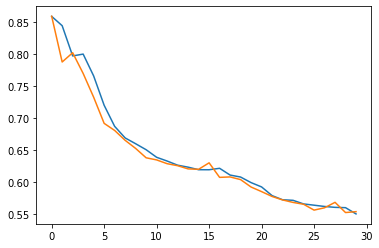

In [160]:
plt.plot(train_history)
plt.plot(test_history);

In [27]:
if best_weights:
    sae.load_state_dict(best_weights)
ids = torch.randperm(X_test.size(1))
sae(X_test[:,ids]).squeeze(), X_test[:,ids].squeeze()

(tensor([[-0.5871, -0.5939, -0.6055,  ..., -0.5989, -0.5627, -0.5252],
         [-0.5540, -0.5606, -0.5718,  ..., -0.5654, -0.5305, -0.4943],
         [-0.5494, -0.5570, -0.5701,  ..., -0.5626, -0.5221, -0.4801],
         ...,
         [-1.8614, -1.8478, -1.8245,  ..., -1.8378, -1.9100, -1.9847],
         [-1.8533, -1.8388, -1.8140,  ..., -1.8282, -1.9050, -1.9846],
         [-1.8330, -1.8193, -1.7956,  ..., -1.8091, -1.8822, -1.9580]],
        grad_fn=<SqueezeBackward0>),
 tensor([[-0.5723, -0.6629, -0.6653,  ..., -0.5213, -0.5985, -0.6303],
         [-0.5737, -0.6550, -0.6368,  ..., -0.4891, -0.5762, -0.5871],
         [-0.6026, -0.6347, -0.6397,  ..., -0.5139, -0.6023, -0.5301],
         ...,
         [-1.8439, -1.8251, -1.7937,  ..., -1.8122, -1.9104, -2.0121],
         [-1.8455, -1.8269, -1.7953,  ..., -1.8136, -1.9118, -2.0148],
         [-1.8467, -1.8284, -1.7969,  ..., -1.8147, -1.9125, -2.0159]]))

## Classifier for Time Series

In [31]:
class SeqClassifier(ConvEncoder):
    def __init__(self, emb_size, n_classes, channels, kernel_size=7):
        super().__init__(emb_size, n_classes, channels, kernel_size)

    def forward(self, X):
        return super().forward(X)
    
    def predict_probs(self, X):
        return super().forward(X).softmax(1)
    
    def predict(self, X):
        return super().forward(X).argmax(1)

In [36]:
net = SeqClassifier(1, 2, [2, 4, 8], kernel_size=7).to(device)
opt = optim.Adam(net.parameters(), 1e-2)
sch = optim.lr_scheduler.StepLR(opt, 2, .999)

criterion = nn.CrossEntropyLoss()

# training procedure
best_weights = None
best_score = [float('inf')]
train_history, test_history = [], []
def train_clf(num_epochs, mode, verbose=True):
    for epoch in range(num_epochs):
        train_loss = []
        for bx,by in get_batches(X_train, y_train, mode=mode):
            opt.zero_grad()
            y_pred = net(bx)
            loss = criterion(y_pred, by)
            loss.backward()
            train_loss.append(loss.item())
            opt.step()
        sch.step()
        train_history.append(np.mean(train_loss))
        test_loss = criterion(net(X_test), y_test).item()
        test_history.append(test_loss)
        if verbose:
            print(f'Epoch #{epoch}\n------')
            print(train_history[-1])
            print(test_history[-1], '\n')
        if test_loss < best_score[0]:
            best_score[0] = test_loss
            best_weights = copy.deepcopy(net.state_dict())

In [ ]:
train_clf(100, mode, False)

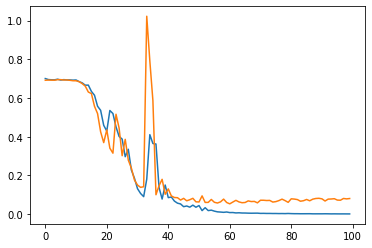

In [39]:
plt.plot(train_history);
plt.plot(test_history);

In [40]:
net.predict(X_test), y_test

(tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]))

## Augmentation

In [154]:
def oversampling(X, y, augments, k=3, sign=-1):
    """
    sign = -1 -> intrapolation
    sign = +1 -> extrapolation
    """
    new_X, new_y = [], []
    for lbl, m in enumerate(augments):
        X_lbl = X[y==lbl]
        m_ids = torch.multinomial(
            torch.ones(len(X_lbl)), m, replacement=True)
        lambda_ = X.new(m).uniform_(.3, .7)[:, None, None]
        
        mX_lbl = X_lbl[m_ids]
        mk_ids = torch.norm(
            X_lbl - mX_lbl[:,None], dim=2
        ).topk(k, dim=1)[1]
        
        new_X.append(
            (lambda_*sign*(mX_lbl[:,None]-X_lbl[mk_ids])
             + mX_lbl[:,None]).flatten(0,1))
        new_y.append(torch.tensor([lbl]*m*k))
    return torch.cat(new_X), torch.cat(new_y)

In [ ]:
code = sae.enc(X_train).detach()

augmented_X, augmented_y = [], []

# Balance the number of class representators
cnts = y_train.bincount()
augments = cnts.max().item() - cnts
if any(augments):
    new_code, new_y = oversampling(code, y_train, augments)
    new_X = sae.dec(new_code).detach()
    augmented_X.append(new_X)
    augmented_y.append(new_y)
    
M = 10  # chose M: <!! each class will grow by M !!>
# Equal augmentation
augments = [M] * len(cnts)
new_code, new_y = oversampling(code, y_train, augments)
new_X = sae.dec(new_code).detach()
augmented_X.append(new_X)
augmented_y.append(new_y)

augmented_X, augmented_y = map(torch.cat, (augmented_X, augmented_y))

In [159]:
# Data augmentation by adding gaussian noise

# !! Take into consideration that noise here is being applied
# to balanced and already augmented by inter/extra-polation dataset !!

code = sae.enc(augmented_X).detach()
new_code = code + .05*torch.randn_like(code)
augmented_X = torch.cat([augmented_X, sae.dec(new_code).detach()])
augmented_y = torch.cat([augmented_y, augmented_y])

## Multivariate Data

In [2]:
set_id = 1
mode = 'cnn'
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

sets = ['Libras', 'HandMovementDirection']
name = sets[set_id]

folder = Path('multivar_times_series')
X_train_raw, y_train_raw = load_from_arff_to_dataframe(
    folder/name/f'{name}_TRAIN.arff')
X_test_raw, y_test_raw = load_from_arff_to_dataframe(
    folder/name/f'{name}_TEST.arff')

print(f'\nShape of the training dataset: {X_train_raw.shape}')
X_train_raw.head()


Shape of the training dataset: (160, 10)


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9
0,0 152.472131 1 151.149948 2 133...,0 12.392351 1 77.166998 2 75.53...,0 18.801367 1 7.669297 2 20...,0 119.067984 1 92.378960 2 50...,0 9.371185 1 28.596053 2 33...,0 176.878290 1 134.774572 2 77...,0 187.217536 1 181.612639 2 143...,0 148.597142 1 -7.859846 2 -75...,0 192.406885 1 123.777559 2 37...,0 125.757108 1 -38.720199 2 -86...
1,0 -13.040644 1 12.830811 2 -3...,0 19.233769 1 -4.991483 2 -16...,0 66.933527 1 124.618288 2 98...,0 -35.137874 1 1.701522 2 25...,0 50.791490 1 221.224243 2 252...,0 -154.184133 1 -26.774156 2 45...,0 30.970773 1 148.602671 2 160...,0 -208.111167 1 -192.617816 2 -181...,0 -130.664900 1 -63.905838 2 -15...,0 -195.935521 1 -19.472038 2 56...
2,0 347.753571 1 283.267749 2 242...,0 197.774774 1 150.099303 2 117...,0 63.838660 1 63.824220 2 84...,0 245.984713 1 162.896918 2 108...,0 210.905239 1 144.768204 2 94...,0 280.506386 1 206.246174 2 170...,0 354.705629 1 262.012640 2 168...,0 223.814706 1 122.452679 2 65...,0 207.523094 1 182.589754 2 126...,0 303.975308 1 168.434157 2 65...
3,0 -233.910173 1 -263.752715 2 -250...,0 -187.467394 1 -142.395013 2 -135...,0 -86.571985 1 -47.182563 2 -6...,0 -184.676555 1 -195.306612 2 -141...,0 -108.266154 1 124.377494 2 200...,0 -231.688096 1 -179.703892 2 -97...,0 -262.399832 1 -32.974744 2 89...,0 -105.677538 1 42.209137 2 118...,0 -82.033333 1 -67.506163 2 -82...,0 -140.012384 1 0.278821 2 71...
4,0 109.304340 1 64.749574 2 25...,0 201.260745 1 50.199130 2 -39...,0 14.521665 1 -88.523783 2 -152...,0 195.652441 1 196.864336 2 165...,0 125.077312 1 4.943108 2 -43...,0 211.538165 1 184.857103 2 152...,0 238.791210 1 170.498851 2 137...,0 66.915634 1 147.337646 2 126...,0 69.283736 1 88.357515 2 67...,0 160.787868 1 239.187795 2 229...


In [3]:
# for rnn SAE
X = []
for v in X_train_raw.values: X.append(v[0])
if mode == 'rnn':
    X_train = torch.Tensor(X).permute(1,0)[...,None]
    y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
else:
    X_train = torch.Tensor(X)[:,None]
    y_train = torch.LongTensor(pd.factorize(y_train_raw)[0])
X_train, y_train = X_train.to(device), y_train.to(device)

X = []
for v in X_test_raw.values: X.append(v[0])
if mode == 'rnn':
    X_test = torch.Tensor(X).permute(1,0)[...,None]
    y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
else:
    X_test = torch.Tensor(X)[:,None]
    y_test = torch.LongTensor(pd.factorize(y_test_raw)[0])
X_test, y_test = X_test.to(device), y_test.to(device)

## Taking into Account Persistence Landscapes

1st option

In [25]:
# Input: (batch_size, feature_level, num_layers, n_bins)
# The last 3 form 'shape' 3-tuple 

# TEST WITH AND WITHOUT BATCH NORM LAYER

class LandscapeInverse(nn.Module):
    def __init__(
        self, emb_size, shape,
        seq_length, channels, kernel_size=28):
        super().__init__()
        
        channels.append(emb_size)
        channels.insert(0, shape[0]*shape[1])
        self.tb = DCConvStack(channels, kernel_size, len(channels)-1)
        self.proj = nn.Sequential(
                    nn.Linear(shape[2], seq_length),
                    nn.BatchNorm1d(shape[0]*shape[1]),
                    nn.LeakyReLU(.2, inplace=True))
    
    def forward(self, landscape):
        return self.tb(self.proj(landscape.flatten(1,2)))
    
    # if landscapy is not a torch.Tensor, substitute `.flatten(1,2)`
    # with `torch.flatten(<>, 1, 2)`

In [30]:
pli = LandscapeInverse(2, (2, 1, 50), 286, [32, 64])
x = torch.rand(28, 2, 1, 50)
pli(x).shape

torch.Size([28, 2, 286])

2nd option

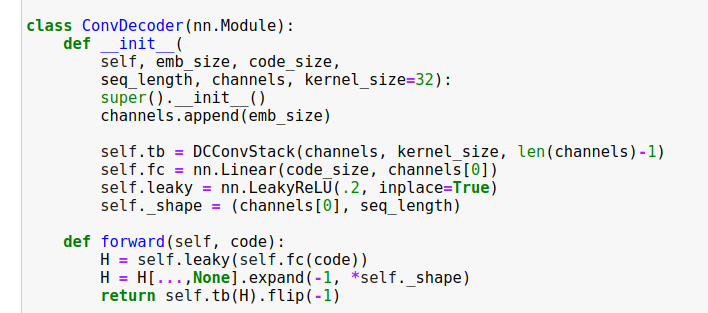

In [35]:
# forward's input: 
#    @param landscape (batch_size, feature_level, num_layers, n_bins)
#    The last 3 form 'shape' 3-tuple 

#    @param code (batch_size, code_size)

class StackDecoder(nn.Module):
    def __init__(
        self, emb_size, code_size, shape,
        seq_length, channels, kernel_size=28):
        super().__init__()
        
        channels.append(emb_size)
        self._shape = (channels[0], seq_length)
        self.tb = DCConvStack(channels, kernel_size, len(channels)-1)
        self.proj1 = nn.Sequential(
                    nn.Linear(np.prod(shape), code_size),
                    nn.BatchNorm1d(code_size),
                    nn.LeakyReLU(.2, inplace=True))
        self.proj2 = nn.Sequential(
                    nn.Linear(code_size*2, channels[0]),
                    nn.BatchNorm1d(channels[0]),
                    nn.LeakyReLU(.2, inplace=True))
    
    def forward(self, code, landscape):
        H = torch.cat([code, self.proj1(landscape.flatten(1))], 1)
        H = self.proj2(H)[...,None].expand(-1, *self._shape)
        return self.tb(H)
    
    # if landscapy is not a torch.Tensor, substitute `.flatten(1,2)`
    # with `torch.flatten(<>, 1, 2)`

In [36]:
sdec = StackDecoder(2, 100, (2, 1, 50), 286, [32, 64])
pl = torch.rand(28, 2, 1, 50)
code = torch.rand(28, 100)
sdec(code, pl).shape

torch.Size([28, 2, 286])

---

## Draft (functions related to other parts)

In [150]:
def triangle_hat(x, a, b):
    out = torch.zeros_like(x)
    left_slope = (x > a) & (x < .5*(a+b))
    right_slope = (x >= .5*(a+b)) & (x < b)
    out[left_slope] = (x - a)[left_slope]
    out[right_slope] = (b - x)[right_slope]
    return out

def discretize(data, lims, n_bins=100):
    sh = data.shape[:-1]
    a = data[..., 0][..., None].expand(*sh, n_bins)
    b = data[..., 1][..., None].expand(*sh, n_bins)
    x = torch.linspace(*lims, n_bins)
    return x, triangle_hat(x.expand(*sh, -1), a, b)

tensor([0.2563, 0.5506])


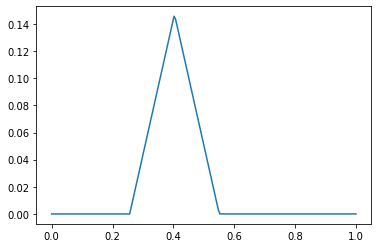

In [153]:
data = torch.rand(3, 4, 2)
print(data[0, 0])
x, hats = discretize(data, (0, 1), 200)
plt.plot(x, hats[0, 0]);